# **INTRODUCTION**

This project explores the use of various machine learning algorithms to analyze a dataset of COVID-19 patient information, with the aim of identifying patterns and predictors related to patient outcomes. The researchers applied a diverse set of classification models, including Logistic Regression, Naive Bayes, Decision Trees, Support Vector Machines, AdaBoost, RandomForest, and XGBoost, to predict patient mortality based on a range of clinical and demographic features. The performance of these models was evaluated using the Receiver Operating Characteristic (ROC) curve and the Area Under the Curve (AUC) metric, which assessed their ability to distinguish between the survival and death of COVID-19 patients.

# **IMPORTING LIBRARIES**


In [ ]:
# Importing essential libraries and modules for data handling, visualization, machine learning modeling, and performance evaluation.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn modules for preprocessing and model selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# sklearn modules for the models and ensemble methods
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# sklearn modules for performance metrics
from sklearn.metrics import accuracy_score, confusionatrix, classification_report
from sklearn.metrics import roc_curve, auc

# sklearn modules for model selection and evaluation
from sklearn.metrics import recall_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV

# scipy module for defining a uniform random distribution
from scipy.stats import uniform, randint

# **READING DATA AND DATA DISPLAY**

In [ ]:
# Setting up PySpark to work with Spark using Python
pip install pyspark

In [ ]:
# Importing SparkSession from PySpark
from pyspark.sql import SparkSession

# Initializing a SparkSession
spark = SparkSession.builder.appName("Covid").getOrCreate()

# Loading the dataset into a Spark DataFrame with column headers and automatically inferred schema
data = spark.read.csv("/content/Covid Data.csv", header=True, inferSchema=True)

# Displaying the first few rows of the dataframe
data.show()


+-----+------------+---+------------+----------+-------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+---+
|USMER|MEDICAL_UNIT|SEX|PATIENT_TYPE| DATE_DIED|INTUBED|PNEUMONIA|AGE|PREGNANT|DIABETES|COPD|ASTHMA|INMSUPR|HIPERTENSION|OTHER_DISEASE|CARDIOVASCULAR|OBESITY|RENAL_CHRONIC|TOBACCO|CLASIFFICATION_FINAL|ICU|
+-----+------------+---+------------+----------+-------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+---+
|    2|           1|  1|           1|03/05/2020|     97|        1| 65|       2|       2|   2|     2|      2|           1|            2|             2|      2|            2|      2|                   3| 97|
|    2|           1|  2|           1|03/06/2020|     97|        1| 72|      97|       2|   2|     2|      2|           1|            2|             2|      1|            1|    

# **DATA EXPLORATION**

In [ ]:
# Displaying the shape of the DataFrame
num_rows = data.count()

# Listing all column names in the DataFrame
num_cols = len(data.columns)

# Displaying the schema of the DataFrame to understand the data types present in the dataset.
print(f"DataFrame shape: ({num_rows}, {num_cols})")

DataFrame shape: (1048575, 21)


In [ ]:
for col in data.columns:
    print (col)

USMER
MEDICAL_UNIT
SEX
PATIENT_TYPE
DATE_DIED
INTUBED
PNEUMONIA
AGE
PREGNANT
DIABETES
COPD
ASTHMA
INMSUPR
HIPERTENSION
OTHER_DISEASE
CARDIOVASCULAR
OBESITY
RENAL_CHRONIC
TOBACCO
CLASIFFICATION_FINAL
ICU


In [ ]:
data.printSchema()

root
 |-- USMER: integer (nullable = true)
 |-- MEDICAL_UNIT: integer (nullable = true)
 |-- SEX: integer (nullable = true)
 |-- PATIENT_TYPE: integer (nullable = true)
 |-- DATE_DIED: string (nullable = true)
 |-- INTUBED: integer (nullable = true)
 |-- PNEUMONIA: integer (nullable = true)
 |-- AGE: integer (nullable = true)
 |-- PREGNANT: integer (nullable = true)
 |-- DIABETES: integer (nullable = true)
 |-- COPD: integer (nullable = true)
 |-- ASTHMA: integer (nullable = true)
 |-- INMSUPR: integer (nullable = true)
 |-- HIPERTENSION: integer (nullable = true)
 |-- OTHER_DISEASE: integer (nullable = true)
 |-- CARDIOVASCULAR: integer (nullable = true)
 |-- OBESITY: integer (nullable = true)
 |-- RENAL_CHRONIC: integer (nullable = true)
 |-- TOBACCO: integer (nullable = true)
 |-- CLASIFFICATION_FINAL: integer (nullable = true)
 |-- ICU: integer (nullable = true)



# **Checking for Missing Values**

In [ ]:
# Importing required functions from PySpark SQL
from pyspark.sql.functions import col, sum

# Determining the count of missing values in each column and presenting the results
null_counts = data.select([sum(col(column).isNull().cast("int")).alias(column) for column in data.columns])
null_counts.show()

+-----+------------+---+------------+---------+-------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+---+
|USMER|MEDICAL_UNIT|SEX|PATIENT_TYPE|DATE_DIED|INTUBED|PNEUMONIA|AGE|PREGNANT|DIABETES|COPD|ASTHMA|INMSUPR|HIPERTENSION|OTHER_DISEASE|CARDIOVASCULAR|OBESITY|RENAL_CHRONIC|TOBACCO|CLASIFFICATION_FINAL|ICU|
+-----+------------+---+------------+---------+-------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+---+
|    0|           0|  0|           0|        0|      0|        0|  0|       0|       0|   0|     0|      0|           0|            0|             0|      0|            0|      0|                   0|  0|
+-----+------------+---+------------+---------+-------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+-

# **EXPLORATORY DATA ANALYSIS**

In [ ]:
# Converting Spark DataFrame to Pandas DataFrame for visualization
df = data.select('*')

df.show()


+-----+------------+---+------------+----------+-------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+---+
|USMER|MEDICAL_UNIT|SEX|PATIENT_TYPE| DATE_DIED|INTUBED|PNEUMONIA|AGE|PREGNANT|DIABETES|COPD|ASTHMA|INMSUPR|HIPERTENSION|OTHER_DISEASE|CARDIOVASCULAR|OBESITY|RENAL_CHRONIC|TOBACCO|CLASIFFICATION_FINAL|ICU|
+-----+------------+---+------------+----------+-------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+---+
|    2|           1|  1|           1|03/05/2020|     97|        1| 65|       2|       2|   2|     2|      2|           1|            2|             2|      2|            2|      2|                   3| 97|
|    2|           1|  2|           1|03/06/2020|     97|        1| 72|      97|       2|   2|     2|      2|           1|            2|             2|      1|            1|    

To visualize the data, the Spark DataFrame is transformed into a Pandas DataFrame. Next, histograms are created for each feature in the dataset, using 10 bins. The histograms are displayed with a figure size of 14 by 14 inches, providing a visual overview of the distribution and frequency of values across the various features.These are crucial for conducting Exploratory Data Analysis (EDA). They assist in comprehending the distribution of variables, detecting outliers, and uncovering initial insights about trends or patterns present in the data.

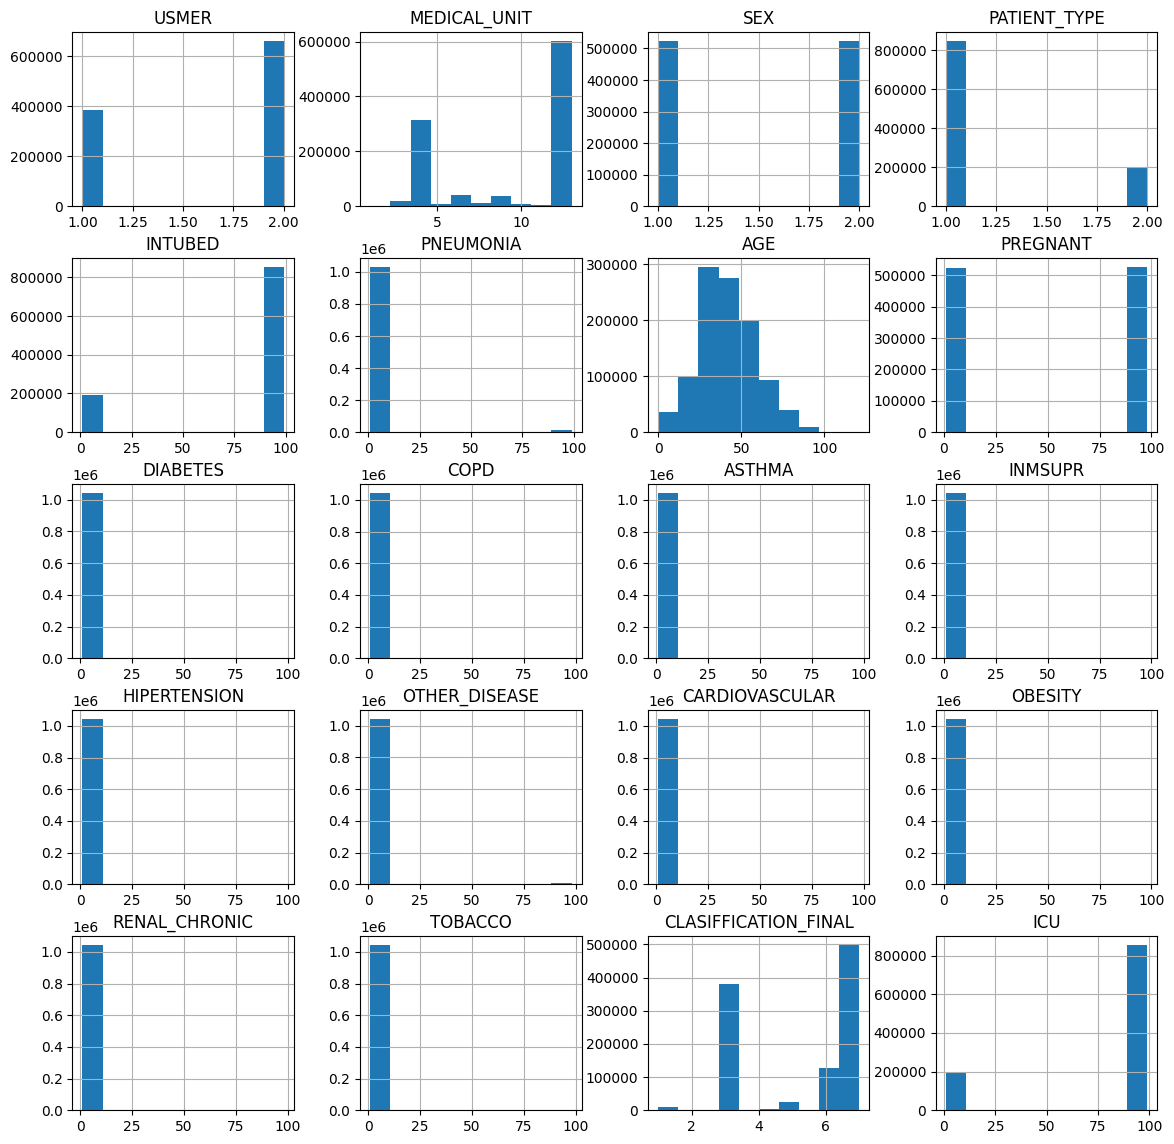

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col

# Generating histograms for each feature in the DataFrame
df_pd = df.toPandas()

df_pd.hist(bins = 10 , figsize= (14,14))
plt.show()

# **DATA CLEANING AND FEATURE ENGINEERING**

In [ ]:
# Importing essential functions from PySpark SQL
from pyspark.sql.functions import when, col
from pyspark.sql.types import StringType

# The code creates a new feature called 'DEATH' from the existing 'DATE_DIED' column. If the value in 'DATE_DIED' is '9999-99-99', it is replaced with 0,
# indicating that no death has occurred. For all other values in 'DATE_DIED', the new 'DEATH' feature is set to 1, indicating that a death has occurred.
df = df.withColumn("DATE_DIED", col("DATE_DIED").cast(StringType()))

# Now, apply the conditional logic
df = df.withColumn("DATE_DIED",
                   when(col("DATE_DIED") != "9999-99-99", 1)
                   .otherwise(0))

# For validation, showing the distribution of the 'DATE_DIED' after replacement
df.groupBy("DATE_DIED").count().show()

# Creating a new column 'DEATH' which is a copy of 'DATE_DIED'
df = df.withColumn("DEATH", col("DATE_DIED"))

# Show the first 20 rows for checking
df.show(20)

+---------+------+
|DATE_DIED| count|
+---------+------+
|        1| 76942|
|        0|971633|
+---------+------+

+-----+------------+---+------------+---------+-------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+---+-----+
|USMER|MEDICAL_UNIT|SEX|PATIENT_TYPE|DATE_DIED|INTUBED|PNEUMONIA|AGE|PREGNANT|DIABETES|COPD|ASTHMA|INMSUPR|HIPERTENSION|OTHER_DISEASE|CARDIOVASCULAR|OBESITY|RENAL_CHRONIC|TOBACCO|CLASIFFICATION_FINAL|ICU|DEATH|
+-----+------------+---+------------+---------+-------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+---+-----+
|    2|           1|  1|           1|        1|     97|        1| 65|       2|       2|   2|     2|      2|           1|            2|             2|      2|            2|      2|                   3| 97|    1|
|    2|           1|  2|           1|    

The 'DATE_DIED' column, which denotes whether a patient has passed away, is transformed from a string format to a binary indicator. In this new format, the value '9999-99-99' represents survival (coded as 0), while any other date indicates death (coded as 1). The recoded column is displayed for validation, along with the count distribution of the new binary feature.

**Death Counts and Imbalance**

In [ ]:
# Calculating the death count grouped by the 'DEATH' column and showing the results.
death_counts = df.groupBy('DEATH').count()
death_counts.show()

+-----+------+
|DEATH| count|
+-----+------+
|    1| 76942|
|    0|971633|
+-----+------+



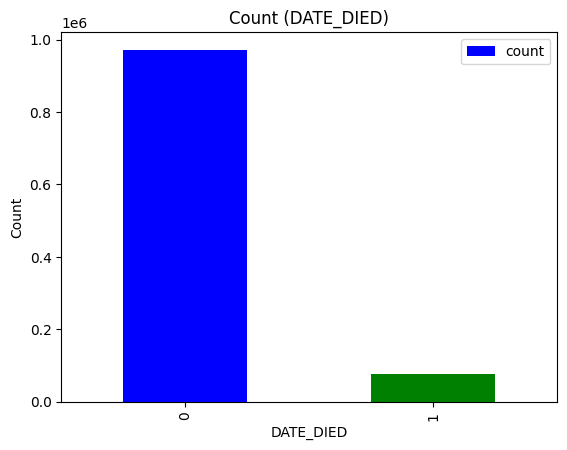

In [ ]:
# Sorting the number of deaths in descending order for easier visualization.
date_died_counts = df.groupBy('DATE_DIED').count().orderBy('count', ascending=False)

# Converting the resulting DataFrame to Pandas for visualization
date_died_counts_pd = date_died_counts.toPandas()

# Plotting a bar graph of the counts of deaths
date_died_counts_pd.plot(kind='bar', x='DATE_DIED', y='count', title='Count (DATE_DIED)', color=['b', 'g'])
plt.xlabel('DATE_DIED')
plt.ylabel('Count')
plt.show()

- This code segment groups the dataset based on the 'DEATH' column to determine the frequency of each class (deaths and survivals). The resulting visualization, a bar chart, clearly demonstrates the significant class imbalance, suggesting that techniques to address this imbalance may be necessary before proceeding with the modeling process.

In [ ]:
df = df.drop("DATE_DIED")
df.show()

+-----+------------+---+------------+-------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+---+-----+
|USMER|MEDICAL_UNIT|SEX|PATIENT_TYPE|INTUBED|PNEUMONIA|AGE|PREGNANT|DIABETES|COPD|ASTHMA|INMSUPR|HIPERTENSION|OTHER_DISEASE|CARDIOVASCULAR|OBESITY|RENAL_CHRONIC|TOBACCO|CLASIFFICATION_FINAL|ICU|DEATH|
+-----+------------+---+------------+-------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+---+-----+
|    2|           1|  1|           1|     97|        1| 65|       2|       2|   2|     2|      2|           1|            2|             2|      2|            2|      2|                   3| 97|    1|
|    2|           1|  2|           1|     97|        1| 72|      97|       2|   2|     2|      2|           1|            2|             2|      1|            1|      2|                   5| 97|  

In [ ]:
sex_counts = df.groupBy('SEX').count()
sex_counts.show()

+---+------+
|SEX| count|
+---+------+
|  1|525064|
|  2|523511|
+---+------+



# **FEATURE ENCODING AND DATA CLEANING**

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col

df = df.withColumn('SEX',
                   when(col('SEX') == 1, 'Female').when(col('SEX') == 2, 'Male').otherwise(col('SEX')))

df.show()

+-----+------------+------+------------+-------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+---+-----+
|USMER|MEDICAL_UNIT|   SEX|PATIENT_TYPE|INTUBED|PNEUMONIA|AGE|PREGNANT|DIABETES|COPD|ASTHMA|INMSUPR|HIPERTENSION|OTHER_DISEASE|CARDIOVASCULAR|OBESITY|RENAL_CHRONIC|TOBACCO|CLASIFFICATION_FINAL|ICU|DEATH|
+-----+------------+------+------------+-------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+---+-----+
|    2|           1|Female|           1|     97|        1| 65|       2|       2|   2|     2|      2|           1|            2|             2|      2|            2|      2|                   3| 97|    1|
|    2|           1|  Male|           1|     97|        1| 72|      97|       2|   2|     2|      2|           1|            2|             2|      1|            1|      2|            

In [ ]:
# Grouping by 'SEX' and 'PREGNANT' to count the occurrences and display them
grouped_counts = df.groupBy('SEX', 'PREGNANT').count()
grouped_counts.show()

+------+--------+------+
|   SEX|PREGNANT| count|
+------+--------+------+
|Female|      98|  3754|
|Female|       2|513179|
|  Male|      97|523511|
|Female|       1|  8131|
+------+--------+------+



- PREGNANT value equals to 97 for every string for male sex. So every man has the value 97 in PREGNANT column due to the fact that men can't be pregnant. It means that we can replace this value by 0. We see that when doctors don't have any info about women pregnancy they put 98 value to the PREGNANT column

In [ ]:
import numpy as np
from pyspark.sql.functions import when

# Cleaning data: Replacing the placeholder value 97 in the 'PREGNANT' column
# for male patients with 0, as men cannot be pregnant.
# Replacing unknown pregnancy information (98) with np.nan for appropriate handling.
df = df.withColumn('PREGNANT', when(df['PREGNANT'] == 97, 0).otherwise(df['PREGNANT']))
df = df.withColumn('PREGNANT', when(df['PREGNANT'] == 98, np.nan).otherwise(df['PREGNANT']))

df.show()

+-----+------------+------+------------+-------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+---+-----+
|USMER|MEDICAL_UNIT|   SEX|PATIENT_TYPE|INTUBED|PNEUMONIA|AGE|PREGNANT|DIABETES|COPD|ASTHMA|INMSUPR|HIPERTENSION|OTHER_DISEASE|CARDIOVASCULAR|OBESITY|RENAL_CHRONIC|TOBACCO|CLASIFFICATION_FINAL|ICU|DEATH|
+-----+------------+------+------------+-------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+---+-----+
|    2|           1|Female|           1|     97|        1| 65|     2.0|       2|   2|     2|      2|           1|            2|             2|      2|            2|      2|                   3| 97|    1|
|    2|           1|  Male|           1|     97|        1| 72|     0.0|       2|   2|     2|      2|           1|            2|             2|      1|            1|      2|            

In [ ]:
grouped_counts = df.groupBy('SEX', 'PREGNANT').count()
grouped_counts.show()

+------+--------+------+
|   SEX|PREGNANT| count|
+------+--------+------+
|  Male|     0.0|523511|
|Female|     2.0|513179|
|Female|     NaN|  3754|
|Female|     1.0|  8131|
+------+--------+------+



In [ ]:
null_count = df.filter(df['PREGNANT'].isNull() | (df['PREGNANT'] == 'NaN')).count()

print("Number of null values in 'PREGNANT' column:", null_count)


Number of null values in 'PREGNANT' column: 3754


In [ ]:
from pyspark.sql.functions import when

df = df.withColumn('USMER', when(df['USMER'] == 2.0, 0).otherwise(df['USMER']))
df = df.withColumn('SEX', when(df['SEX'] == 2.0, 0).otherwise(df['SEX']))
df = df.withColumn('PATIENT_TYPE', when(df['PATIENT_TYPE'] == 2.0, 0).otherwise(df['PATIENT_TYPE']))
df = df.withColumn('INTUBED', when(df['INTUBED'] == 2.0, 0).otherwise(df['INTUBED']))
df = df.withColumn('PNEUMONIA', when(df['PNEUMONIA'] == 2.0, 0).otherwise(df['PNEUMONIA']))
df = df.withColumn('PREGNANT', when(df['PREGNANT'] == 2.0, 0).otherwise(df['PREGNANT']))
df = df.withColumn('DIABETES', when(df['DIABETES'] == 2.0, 0).otherwise(df['DIABETES']))
df = df.withColumn('COPD', when(df['COPD'] == 2.0, 0).otherwise(df['COPD']))
df = df.withColumn('ASTHMA', when(df['ASTHMA'] == 2.0, 0).otherwise(df['ASTHMA']))
df = df.withColumn('INMSUPR', when(df['INMSUPR'] == 2.0, 0).otherwise(df['INMSUPR']))
df = df.withColumn('HIPERTENSION', when(df['HIPERTENSION'] == 2.0, 0).otherwise(df['HIPERTENSION']))
df = df.withColumn('OTHER_DISEASE', when(df['OTHER_DISEASE'] == 2.0, 0).otherwise(df['OTHER_DISEASE']))
df = df.withColumn('CARDIOVASCULAR', when(df['CARDIOVASCULAR'] == 2.0, 0).otherwise(df['CARDIOVASCULAR']))
df = df.withColumn('OBESITY', when(df['OBESITY'] == 2.0, 0).otherwise(df['OBESITY']))
df = df.withColumn('RENAL_CHRONIC', when(df['RENAL_CHRONIC'] == 2.0, 0).otherwise(df['RENAL_CHRONIC']))
df = df.withColumn('TOBACCO', when(df['TOBACCO'] == 2.0, 0).otherwise(df['TOBACCO']))
df = df.withColumn('ICU', when(df['ICU'] == 2.0, 0).otherwise(df['ICU']))


df.show()

+-----+------------+------+------------+-------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+---+-----+
|USMER|MEDICAL_UNIT|   SEX|PATIENT_TYPE|INTUBED|PNEUMONIA|AGE|PREGNANT|DIABETES|COPD|ASTHMA|INMSUPR|HIPERTENSION|OTHER_DISEASE|CARDIOVASCULAR|OBESITY|RENAL_CHRONIC|TOBACCO|CLASIFFICATION_FINAL|ICU|DEATH|
+-----+------------+------+------------+-------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+---+-----+
|    0|           1|Female|           1|     97|        1| 65|     0.0|       0|   0|     0|      0|           1|            0|             0|      0|            0|      0|                   3| 97|    1|
|    0|           1|  Male|           1|     97|        1| 72|     0.0|       0|   0|     0|      0|           1|            0|             0|      1|            1|      0|            

In [ ]:
tobacco_counts = df.groupBy('TOBACCO').count()
tobacco_counts.show()

+-------+------+
|TOBACCO| count|
+-------+------+
|      1| 84376|
|     98|  3220|
|      0|960979|
+-------+------+



In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when, col

df = df.withColumn('PATIENT_TYPE',
                   when(col('PATIENT_TYPE') == 1, 'hospitalized').when(col('PATIENT_TYPE') == 0, 'not hospitalized').otherwise(col('PATIENT_TYPE')))

# Show the result to verify the replacement
df.show()


+-----+------------+------+----------------+-------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+---+-----+
|USMER|MEDICAL_UNIT|   SEX|    PATIENT_TYPE|INTUBED|PNEUMONIA|AGE|PREGNANT|DIABETES|COPD|ASTHMA|INMSUPR|HIPERTENSION|OTHER_DISEASE|CARDIOVASCULAR|OBESITY|RENAL_CHRONIC|TOBACCO|CLASIFFICATION_FINAL|ICU|DEATH|
+-----+------------+------+----------------+-------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+---+-----+
|    0|           1|Female|    hospitalized|     97|        1| 65|     0.0|       0|   0|     0|      0|           1|            0|             0|      0|            0|      0|                   3| 97|    1|
|    0|           1|  Male|    hospitalized|     97|        1| 72|     0.0|       0|   0|     0|      0|           1|            0|             0|      1|            1|

In [ ]:
tobacco_counts = df.groupBy('PATIENT_TYPE').count()
tobacco_counts.show()

+----------------+------+
|    PATIENT_TYPE| count|
+----------------+------+
|    hospitalized|848544|
|not hospitalized|200031|
+----------------+------+



In [ ]:
from pyspark.sql.functions import when

values_to_replace = [97, 98, 99]

for column in df.columns:
    df = df.withColumn(column, when(df[column].isin(values_to_replace), None).otherwise(df[column]))



**Data Recoding and Cleaning**

In [ ]:
from pyspark.sql.functions import col, sum

# Recoding categorical values for various features from numerical to string labels for clarity.
# E.g., converting 'SEX' from 1, 2 to 'Female', 'Male'
# The same approach is applied to 'PATIENT_TYPE', 'INTUBED', 'PNEUMONIA', etc.
# This is followed by dropping unnecessary columns and handling missing values by replacement with NaN.

# Verifying the presence of null values after data recoding to maintain data quality and reliability.
null_counts = df.select([sum(col(column).isNull().cast("int")).alias(column) for column in df.columns])

null_counts.show()

+-----+------------+---+------------+-------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+------+-----+
|USMER|MEDICAL_UNIT|SEX|PATIENT_TYPE|INTUBED|PNEUMONIA|AGE|PREGNANT|DIABETES|COPD|ASTHMA|INMSUPR|HIPERTENSION|OTHER_DISEASE|CARDIOVASCULAR|OBESITY|RENAL_CHRONIC|TOBACCO|CLASIFFICATION_FINAL|   ICU|DEATH|
+-----+------------+---+------------+-------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+------+-----+
|    0|           0|  0|           0| 855869|    16003|345|       0|    3338|3003|  2979|   3404|        3104|         5045|          3076|   3032|         3006|   3220|                   0|856032|    0|
+-----+------------+---+------------+-------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+---------------

**Visualization of Missing Data**

<Axes: >

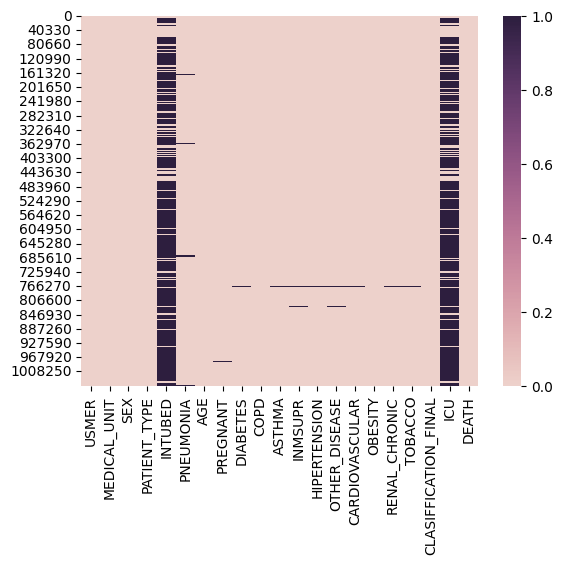

In [ ]:
df_pd = df.toPandas()

# Generating a heatmap of missing values across different features.
sns.heatmap(df_pd.isnull(),cmap=sns.cubehelix_palette(as_cmap=True))

The heatmap presented here depicts the distribution of missing values across the dataset. Each column corresponds to a feature, and the presence of dark lines indicates the existence of missing data. This visualization is essential for recognizing patterns in the missing data, which can guide the selection of an appropriate imputation method or uncover potential biases in the data collection process.

**Data Distribution & Visualization**

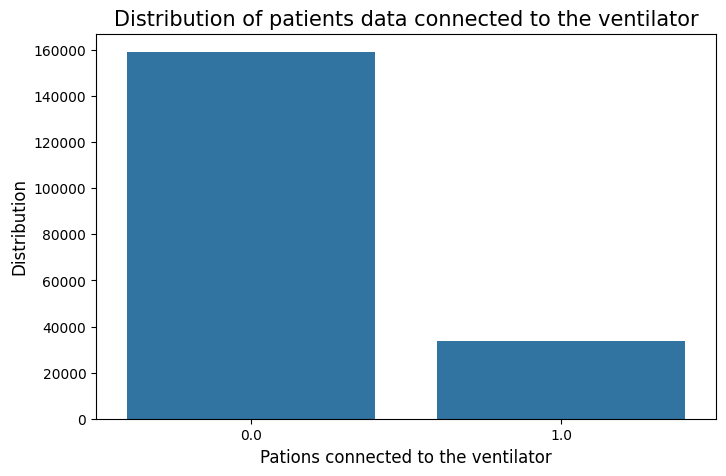

In [ ]:
# Generating a bar chart to visualize the distribution of patients who were intubated and those who were not intubated, based on the 'INTUBED' feature.
plt.figure(figsize = (8,5))
sns.countplot(x = df_pd['INTUBED'])
plt.xlabel('Pations connected to the ventilator', fontsize = 12)
plt.ylabel('Distribution', fontsize = 12)
plt.title('Distribution of patients data connected to the ventilator', fontsize = 15,)
plt.show()

In [ ]:
columns_to_drop = ["INTUBED", "ICU"]
df = df.drop(*columns_to_drop)

**Handling Missing Values**

In [ ]:
from pyspark.sql.functions import col, sum

# Utilizing the PySpark SQL functions to determine the number of null values present in each column of the dataset.
null_counts = df.select([sum(col(column).isNull().cast("int")).alias(column) for column in df.columns])
null_counts.show()

+-----+------------+---+------------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+-----+
|USMER|MEDICAL_UNIT|SEX|PATIENT_TYPE|PNEUMONIA|AGE|PREGNANT|DIABETES|COPD|ASTHMA|INMSUPR|HIPERTENSION|OTHER_DISEASE|CARDIOVASCULAR|OBESITY|RENAL_CHRONIC|TOBACCO|CLASIFFICATION_FINAL|DEATH|
+-----+------------+---+------------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+-----+
|    0|           0|  0|           0|    16003|345|       0|    3338|3003|  2979|   3404|        3104|         5045|          3076|   3032|         3006|   3220|                   0|    0|
+-----+------------+---+------------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+-----+



In [ ]:
# Displaying unique values in the 'PREGNANT' column to understand its distribution
df.select('PREGNANT').distinct().show()

+--------+
|PREGNANT|
+--------+
|     0.0|
|     NaN|
|     1.0|
+--------+



**Imputation with Random Values**

Here, missing values in selected columns are filled with random existing values from the same columns. This is a method to address missing data by maintaining the original distribution of values.

In [ ]:
from pyspark.sql.functions import udf, col, when
from pyspark.sql.types import StringType
import random

# A function is defined to fill nulls in the DataFrame columns with random values from the same column.
# This method helps maintain the distribution of data.
# The function is then applied to specific columns that require imputation.
def fill_nulls_with_random(df, columns):
    for column in columns:
        non_nulls = df.filter(df[column].isNotNull()).select(column).rdd.flatMap(lambda x: x).collect()
        def random_value():
            return random.choice(non_nulls) if non_nulls else None
        random_choice_udf = udf(random_value, StringType())
        df = df.withColumn(f"{column}_random", random_choice_udf()) \
               .withColumn(column, when(col(column).isNull(), col(f"{column}_random")).otherwise(col(column))) \
               .drop(f"{column}_random")

    return df

# Example usage
columns_to_fill = ['PNEUMONIA', 'AGE','PREGNANT','DIABETES','COPD','ASTHMA','INMSUPR','HIPERTENSION','OTHER_DISEASE','CARDIOVASCULAR','OBESITY','RENAL_CHRONIC','TOBACCO','PREGNANT']
df = fill_nulls_with_random(df, columns_to_fill)
df.show()

+-----+------------+------+----------------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+-----+
|USMER|MEDICAL_UNIT|   SEX|    PATIENT_TYPE|PNEUMONIA|AGE|PREGNANT|DIABETES|COPD|ASTHMA|INMSUPR|HIPERTENSION|OTHER_DISEASE|CARDIOVASCULAR|OBESITY|RENAL_CHRONIC|TOBACCO|CLASIFFICATION_FINAL|DEATH|
+-----+------------+------+----------------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+-----+
|    0|           1|Female|    hospitalized|        1| 65|     0.0|       0|   0|     0|      0|           1|            0|             0|      0|            0|      0|                   3|    1|
|    0|           1|  Male|    hospitalized|        1| 72|     0.0|       0|   0|     0|      0|           1|            0|             0|      1|            1|      0|                   5|    1|
|    0|           1|

In [ ]:
from pyspark.sql.functions import col, sum

# After addressing any missing data, a summary of the null values is presented to verify the data's completeness.
# Additionally, the column structure of the DataFrame is displayed to confirm the current state of the data.
null_counts = df.select([sum(col(column).isNull().cast("int")).alias(column) for column in df.columns])
null_counts.show()

+-----+------------+---+------------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+-----+
|USMER|MEDICAL_UNIT|SEX|PATIENT_TYPE|PNEUMONIA|AGE|PREGNANT|DIABETES|COPD|ASTHMA|INMSUPR|HIPERTENSION|OTHER_DISEASE|CARDIOVASCULAR|OBESITY|RENAL_CHRONIC|TOBACCO|CLASIFFICATION_FINAL|DEATH|
+-----+------------+---+------------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+-----+
|    0|           0|  0|           0|        0|  0|       0|       0|   0|     0|      0|           0|            0|             0|      0|            0|      0|                   0|    0|
+-----+------------+---+------------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+-----+



In [ ]:
df.columns

['USMER',
 'MEDICAL_UNIT',
 'SEX',
 'PATIENT_TYPE',
 'PNEUMONIA',
 'AGE',
 'PREGNANT',
 'DIABETES',
 'COPD',
 'ASTHMA',
 'INMSUPR',
 'HIPERTENSION',
 'OTHER_DISEASE',
 'CARDIOVASCULAR',
 'OBESITY',
 'RENAL_CHRONIC',
 'TOBACCO',
 'CLASIFFICATION_FINAL',
 'DEATH']

In [ ]:
sex_counts = df.groupBy('SEX').count()
sex_counts.show()

+------+------+
|   SEX| count|
+------+------+
|Female|525064|
|  Male|523511|
+------+------+



# **EXPLORATORY DATA ANALYSIS**

**Gender Distribution Visualization**

The pie chart visualizes the gender breakdown within the dataset using the Plotly library. The output shows an equal distribution between the genders, which can be a significant factor in maintaining balance and fairness in the subsequent analysis.

In [ ]:
import plotly.graph_objects as go

gender_counts = df.groupBy("SEX").count()

gender_counts_list = gender_counts.collect()

labels = [row['SEX'] for row in gender_counts_list]
values = [row['count'] for row in gender_counts_list]

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
fig.show()


**Age Distribution Visualization**

The code creates age groups and then visualizes the distribution of these groups. This aids in understanding the age composition of the patient population within the dataset.

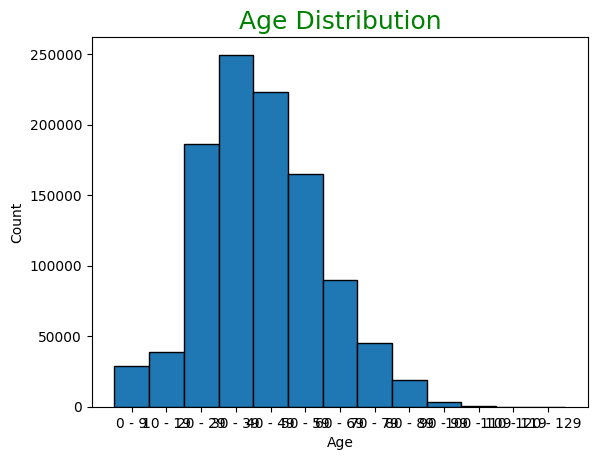

In [ ]:
from pyspark.sql.functions import col, floor
age_bins = df.withColumn("age_bin", floor(col("AGE") / 10) * 10)

age_distribution = age_bins.groupBy("age_bin").count().orderBy("age_bin")

age_distribution_list = age_distribution.collect()

# Extracting bins and counts
bins = [row['age_bin'] for row in age_distribution_list]
counts = [row['count'] for row in age_distribution_list]

# Since we only have the start of each bin, we need to add the last bin end manually if needed
# Plotting
plt.bar(bins, counts, width=10, edgecolor='black')

plt.title("Age Distribution", color="green", fontsize=18)
plt.xlabel("Age")
plt.ylabel("Count")
plt.xticks(bins, [f"{bin} - {bin+9}" for bin in bins])  # Adjust bin labels if necessary

plt.show()

**Age vs. Death Distribution**

This graph, which combines a histogram and a kernel density estimate (KDE), depicts the age distribution for both individuals who survived and those who did not, providing insights into the connections between age and death rates.

<Axes: xlabel='AGE', ylabel='Count'>

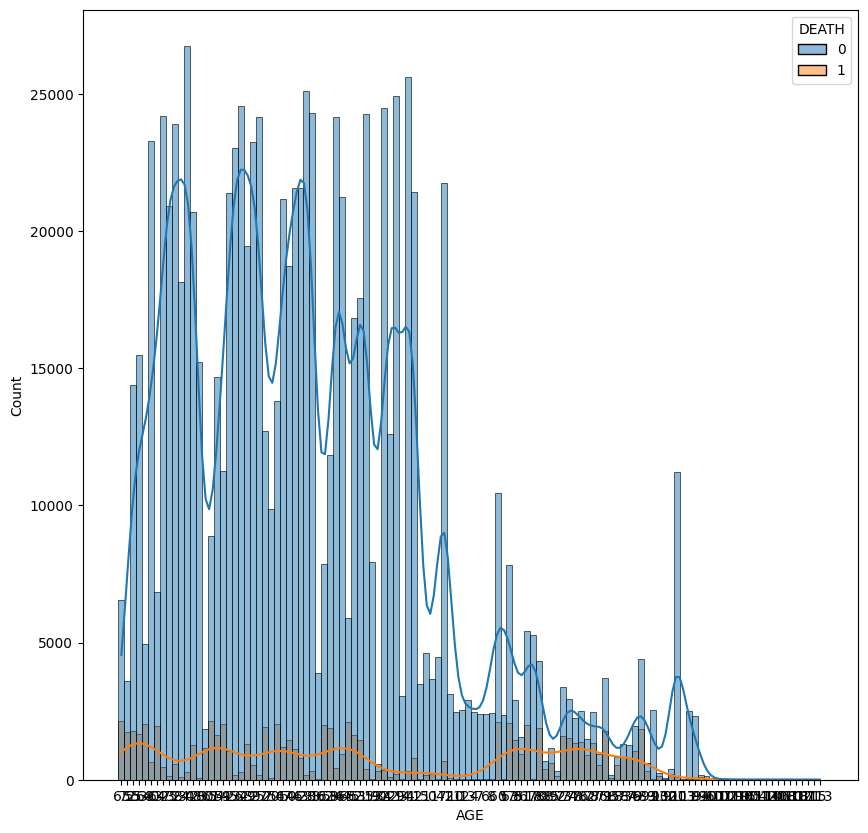

In [ ]:
plt.figure(figsize = (10, 10))
sns.histplot(x = 'AGE', hue = 'DEATH', data = df.toPandas() , kde=True )

**Classification Outcome Counts**

The code analyzes the 'CLASSIFICATION_FINAL' column, tallying the various classification outcomes, including positive and negative COVID-19 results, and presenting them in descending order based on their frequency.

In [ ]:
# Grouping by 'CLASSIFICATION_FINAL' to count the occurrences and displaying the results.
# Ordering the counts in descending order to highlight the most frequent outcomes.
classification_counts = df.groupBy('CLASIFFICATION_FINAL').count().orderBy('count', ascending=False)

classification_counts.show()

+--------------------+------+
|CLASIFFICATION_FINAL| count|
+--------------------+------+
|                   7|499250|
|                   3|381527|
|                   6|128133|
|                   5| 26091|
|                   1|  8601|
|                   4|  3122|
|                   2|  1851|
+--------------------+------+



In [ ]:
classification_counts = df.groupBy("CLASIFFICATION_FINAL").count()

# Sort the results if needed (let's assume descending order of count)
classification_counts = classification_counts.orderBy(col("count").desc())

**Classification Outcome Visualization**

The pie chart provides a visual representation of the relative proportions of each classification outcome, clearly depicting the distribution of test results across the patient population.

In [ ]:
results = classification_counts.collect()

# Extracting labels and values
labels = [row['CLASIFFICATION_FINAL'] for row in results]
values = [row['count'] for row in results]

# Plotly code remains the same
import plotly.graph_objects as go

fig = go.Figure(data=[go.Pie(labels=labels, values=values, pull=[0, 0, 0.2, 0])])
fig.show()

- classification_final: covid test findings. Values 1-3 mean that the patient was diagnosed with covid in different degrees. 4 or higher means that the patient is not a carrier of covid or that the test is inconclusive.

**Patient Type Distribution**

The seaborn barplot compares the ages of patients who were hospitalized with those who were not hospitalized, enabling an analysis of the age distributions between the two patient groups.

<Axes: xlabel='PATIENT_TYPE', ylabel='AGE'>

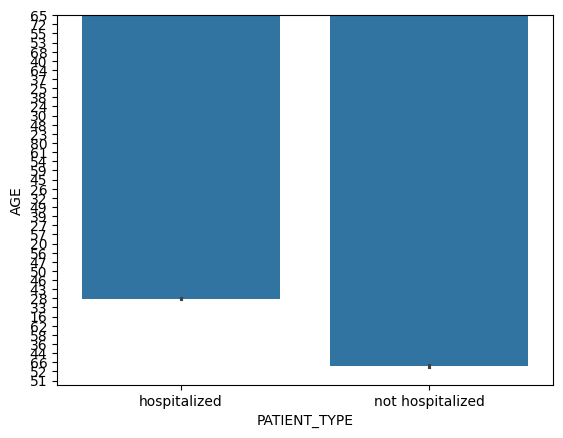

In [ ]:
sns.barplot(data=df.toPandas(), x="PATIENT_TYPE", y="AGE")

In [ ]:

from pyspark.sql.functions import when, col

df = df.withColumn("PATIENT_TYPE",
                   when(col("PATIENT_TYPE") == 1, "hospitalized")
                   .when(col("PATIENT_TYPE") == 0, "not hospitalized")
                   .otherwise(col("PATIENT_TYPE")))


In [ ]:

from pyspark.sql.functions import when, col


df = df.withColumn("CLASIFFICATION_FINAL",
                   when(col("CLASIFFICATION_FINAL").isin([1, 2, 3]), "patient was diagnosed with covid in different degrees")
                   .when(col("CLASIFFICATION_FINAL").isin([4, 5, 6, 7]), "the patient is not a carrier of covid or that the test is inconclusive.")
                   .otherwise(col("CLASIFFICATION_FINAL")))


In [ ]:
from pyspark.sql.functions import col

classification_counts = df.groupBy('CLASIFFICATION_FINAL').count()

# Sort the results in descending order of count
classification_counts = classification_counts.orderBy(col('count').desc())

# Show the result
classification_counts.show()


+--------------------+------+
|CLASIFFICATION_FINAL| count|
+--------------------+------+
|the patient is no...|656596|
|patient was diagn...|391979|
+--------------------+------+



**Classification Outcome Pie Chart**

The visualization offers a breakdown of the dataset's classification results, displayed in a pie chart that shows the proportional frequencies of the different diagnostic groups.

In [ ]:
import plotly.graph_objects as go

# Grouping data by 'CLASSIFICATION_FINAL' and counting the occurrences
gender_counts = df.groupBy("CLASIFFICATION_FINAL").count()

gender_counts_list = gender_counts.collect()

labels = [row['CLASIFFICATION_FINAL'] for row in gender_counts_list]
values = [row['count'] for row in gender_counts_list]

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
fig.show()

**Diabetes Distribution Histogram**

The graph depicts the frequency distribution of individuals with and without diabetes, which is an important factor for examining health results, particularly in the context of a condition like COVID-19.

<Axes: xlabel='DIABETES', ylabel='Count'>

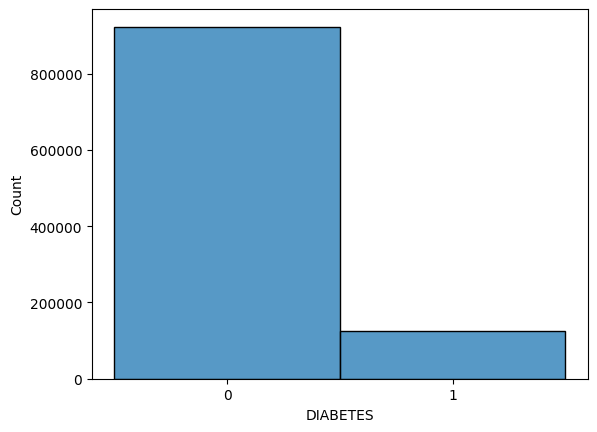

In [ ]:
sns.histplot(data=df.toPandas(), x="DIABETES", kde=False)

**Diabetes vs. Death Countplot**

The provided graph presents a visual representation, a countplot, that illustrates the number of deaths among individuals with and without diabetes. This data highlights the significant influence of pre-existing medical conditions on the mortality rates associated with COVID-19.

<Axes: xlabel='DIABETES', ylabel='count'>

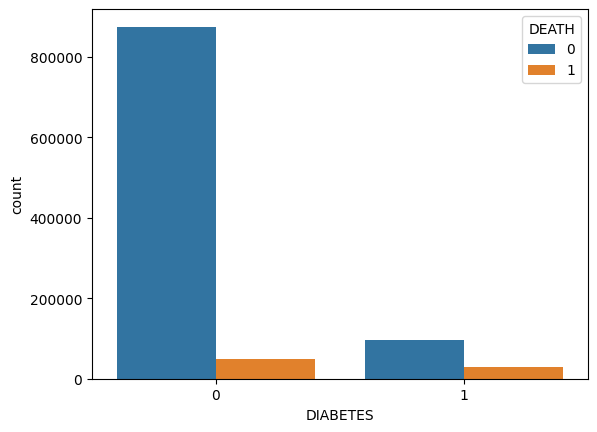

In [ ]:
sns.countplot(data=df.toPandas(), x="DIABETES", hue="DEATH")

**Hypertension vs. Death Countplot**

The provided countplot offers a visual representation of the number of deceased patients with and without hypertension. This information can be valuable in understanding the risk factors linked to complications arising from COVID-19 infections.

<Axes: xlabel='count', ylabel='HIPERTENSION'>

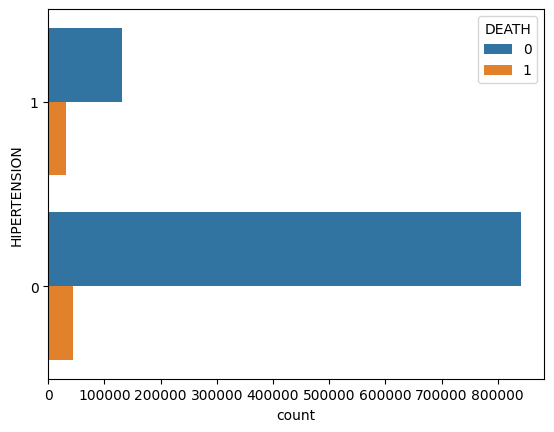

In [ ]:
sns.countplot(data=df.toPandas(), y="HIPERTENSION", hue="DEATH")

**Age vs. Death Stripplot**

The stripplot presents the ages of patients who have succumbed to the illness and those who have recovered, enabling an examination of whether age is a crucial determinant in the mortality rates associated with COVID-19.

<Axes: xlabel='DEATH', ylabel='AGE'>

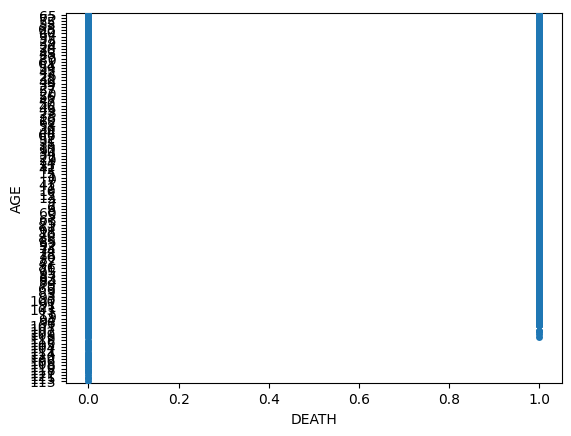

In [ ]:
sns.stripplot(data=df.toPandas(), x="DEATH", y="AGE")

**Sex, Age, and Death Catplot**

The catplot describes a data visualization that uses a bar graph to compare the age distribution between males and females, for both deceased and surviving patients. This type of plot can help uncover demographic trends within the data.

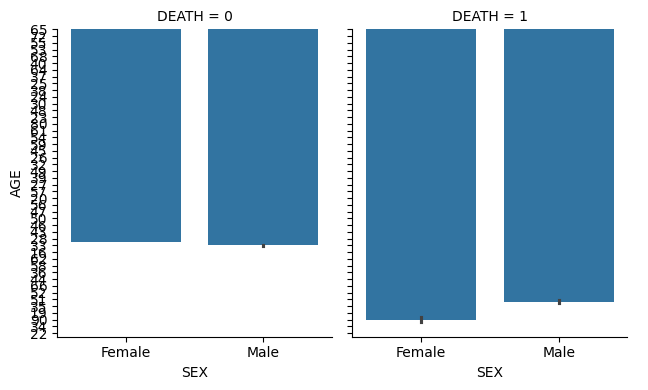

In [ ]:
sns.catplot(
    data=df.toPandas(), x="SEX", y="AGE", col="DEATH",
    kind="bar", height=4, aspect=.8,
)

**Renal Chronic vs. Death Barplot**

In [ ]:
contingency_table = df.groupBy("RENAL_CHRONIC", "DEATH").count()

# Collect the data for plotting
# Note: For large datasets, consider using `toPandas()` cautiously
contingency_data = contingency_table.toPandas()

# Display the aggregated DataFrame
print(contingency_data)

  RENAL_CHRONIC  DEATH   count
0             1      0   13243
1             0      0  958390
2             1      1    5718
3             0      1   71224


The bar graph derived from the pivot table emphasizes the influence of chronic kidney disease on the mortality rates of patients, which is essential for recognizing the vulnerabilities present in the patient population.

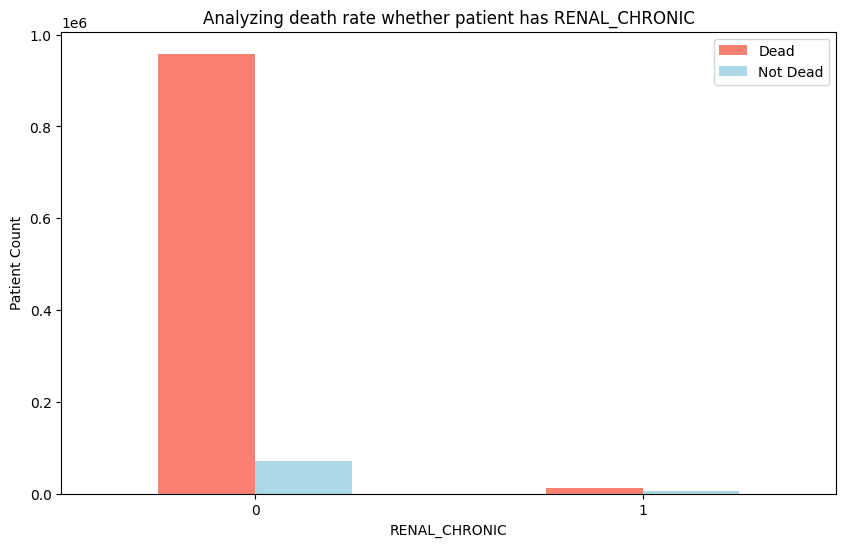

In [ ]:
pivot_table = contingency_data.pivot(index='RENAL_CHRONIC', columns='DEATH', values='count').fillna(0)

# Plot
pivot_table.plot(kind="bar", figsize=(10, 6), color=["salmon", "lightblue"])
plt.title("Analyzing death rate whether patient has RENAL_CHRONIC")
plt.xlabel("RENAL_CHRONIC")
plt.ylabel("Patient Count")
plt.legend(["Dead", "Not Dead"])
plt.xticks(rotation=0)  # Keeping the x-axis labels horizontal for readability
plt.show()

**Asthma vs. Death Countplot**

The visualization differentiates the number of patients who have passed away and those who have survived, based on whether they had asthma or not. This suggests that the presence of asthma as an underlying condition may influence the outcomes of COVID-19 patients.

<Axes: xlabel='ASTHMA', ylabel='count'>

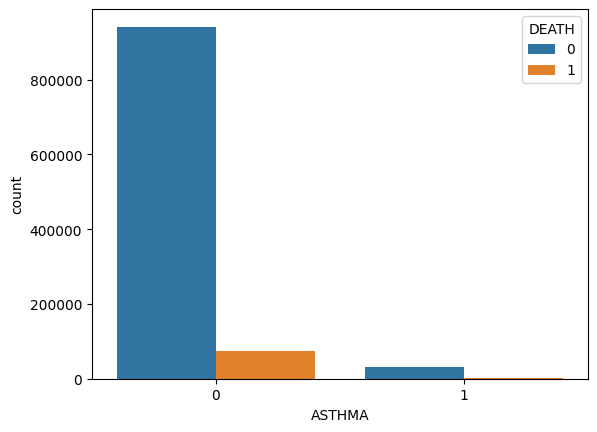

In [ ]:
sns.countplot(data=df.toPandas(), x="ASTHMA", hue="DEATH")

**Pregnancy, Age, and Classification Final Catplot**

The complex catplot describes a complex data visualization that examines the relationship between pregnancy status, age, and the final classification outcome. The data is divided and categorized based on these factors, revealing the intricate interactions between them.

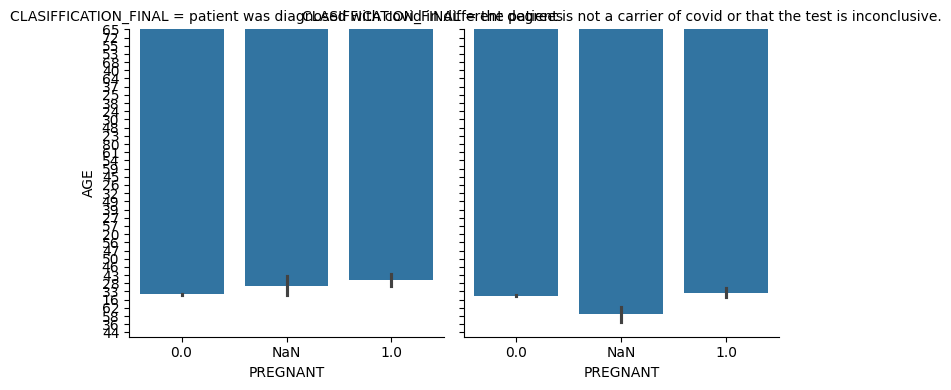

In [ ]:
sns.catplot(
    data=df.toPandas(), x="PREGNANT", y="AGE", col="CLASIFFICATION_FINAL",
    kind="bar", height=4, aspect=.9,
)

**COPD vs. Death Barplot**

The bar graph distinctly illustrates the disparity in death rates between individuals with COPD and those without, highlighting the increased risk associated with respiratory disorders during the pandemic.

In [ ]:
contingency_table = df.groupBy("COPD", "DEATH").count()

# Collect the data for plotting
# Note: For large datasets, consider using `toPandas()` cautiously
contingency_data = contingency_table.toPandas()

# Display the aggregated DataFrame
print(contingency_data)

  COPD  DEATH   count
0    1      0   11067
1    0      0  960566
2    1      1    4039
3    0      1   72903


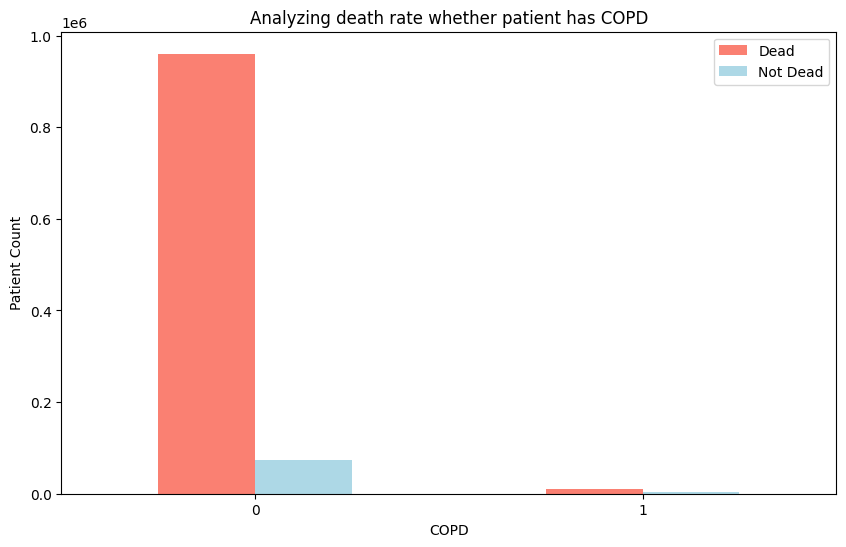

In [ ]:
pivot_table = contingency_data.pivot(index='COPD', columns='DEATH', values='count').fillna(0)

# Plot
pivot_table.plot(kind="bar", figsize=(10, 6), color=["salmon", "lightblue"])
plt.title("Analyzing death rate whether patient has COPD")
plt.xlabel("COPD")
plt.ylabel("Patient Count")
plt.legend(["Dead", "Not Dead"])
plt.xticks(rotation=0)  # Keeping the x-axis labels horizontal for readability
plt.show()

In [ ]:
string_columns = [field.name for field in df.schema.fields if field.dataType == StringType()]

description = df.select(*string_columns).describe()

description.show()

+-------+-------+----------------+-------------------+------------------+--------+-------------------+--------------------+--------------------+--------------------+-------------------+-------------------+-------------------+------------------+-------------------+-------------------+--------------------+
|summary|    SEX|    PATIENT_TYPE|          PNEUMONIA|               AGE|PREGNANT|           DIABETES|                COPD|              ASTHMA|             INMSUPR|       HIPERTENSION|      OTHER_DISEASE|     CARDIOVASCULAR|           OBESITY|      RENAL_CHRONIC|            TOBACCO|CLASIFFICATION_FINAL|
+-------+-------+----------------+-------------------+------------------+--------+-------------------+--------------------+--------------------+--------------------+-------------------+-------------------+-------------------+------------------+-------------------+-------------------+--------------------+
|  count|1048575|         1048575|            1048575|           1048575| 1048575|

**Data Type Conversion**

Ensuring data type consistency is crucial for the effectiveness of machine learning models. In this case, the float columns are converted to 'Int64' data type, which can help mitigate errors that may occur during the model training process and when making predictions. This step is especially important when dealing with features that have categorical or binary data encoded as numeric values.

In [ ]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

cols = ['SEX', 'PATIENT_TYPE', 'CLASIFFICATION_FINAL']
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df) for column in cols]
pipeline = Pipeline(stages=indexers)
df_transformed = pipeline.fit(df).transform(df)

for column in cols:
    df_transformed = df_transformed.drop(column).withColumnRenamed(column + "_index", column)

df_transformed.show()


+-----+------------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+-----+---+------------+--------------------+
|USMER|MEDICAL_UNIT|PNEUMONIA|AGE|PREGNANT|DIABETES|COPD|ASTHMA|INMSUPR|HIPERTENSION|OTHER_DISEASE|CARDIOVASCULAR|OBESITY|RENAL_CHRONIC|TOBACCO|DEATH|SEX|PATIENT_TYPE|CLASIFFICATION_FINAL|
+-----+------------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+-----+---+------------+--------------------+
|    0|           1|        1| 65|     0.0|       0|   0|     0|      0|           1|            0|             0|      0|            0|      0|    1|0.0|         0.0|                 1.0|
|    0|           1|        1| 72|     0.0|       0|   0|     0|      0|           1|            0|             0|      1|            1|      0|    1|1.0|         0.0|                 0.0|
|    0|           1|        0| 55|     0.0|       1|   

In [ ]:
df = df_transformed.toPandas()

In [ ]:
# sex_counts = df_transformed.groupBy('DEATH').count()
# sex_counts.show()

In [ ]:
df['PREGNANT'] = pd.to_numeric(df['PREGNANT'], errors='coerce')

non_nan_values = df['PREGNANT'].dropna().unique()

random_selection = np.random.choice(non_nan_values, size=df['PREGNANT'].isna().sum())

df.loc[df['PREGNANT'].isna(), 'PREGNANT'] = random_selection

In [ ]:
df.head()

,USMER,MEDICAL_UNIT,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,DEATH,SEX,PATIENT_TYPE,CLASIFFICATION_FINAL
0,0,1,1,65,0.0,0,0,0,0,1,0,0,0,0,0,1,0.0,0.0,1.0
1,0,1,1,72,0.0,0,0,0,0,1,0,0,1,1,0,1,1.0,0.0,0.0
2,0,1,0,55,0.0,1,0,0,0,0,0,0,0,0,0,1,1.0,1.0,1.0
3,0,1,0,53,0.0,0,0,0,0,0,0,0,0,0,0,1,0.0,0.0,0.0
4,0,1,0,68,0.0,1,0,0,0,1,0,0,0,0,0,1,1.0,0.0,1.0


In [ ]:
for column in df.columns:
    if df[column].dtype == 'float':
        df[column] = df[column].astype('Int64')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 19 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   USMER                 1048575 non-null  int32 
 1   MEDICAL_UNIT          1048575 non-null  int32 
 2   PNEUMONIA             1048575 non-null  object
 3   AGE                   1048575 non-null  object
 4   PREGNANT              1048575 non-null  Int64 
 5   DIABETES              1048575 non-null  object
 6   COPD                  1048575 non-null  object
 7   ASTHMA                1048575 non-null  object
 8   INMSUPR               1048575 non-null  object
 9   HIPERTENSION          1048575 non-null  object
 10  OTHER_DISEASE         1048575 non-null  object
 11  CARDIOVASCULAR        1048575 non-null  object
 12  OBESITY               1048575 non-null  object
 13  RENAL_CHRONIC         1048575 non-null  object
 14  TOBACCO               1048575 non-null  object
 15

In [ ]:
#Feature Selection

**Correlation Heatmap Analysis**

The correlation heatmap is an essential exploratory tool that unveils the intensity and orientation of linear associations between variables. For example, it can assist in identifying which factors are most strongly linked to outcomes such as hospitalization or mortality, which could be pivotal for risk categorization and prioritizing healthcare interventions.

<Axes: >

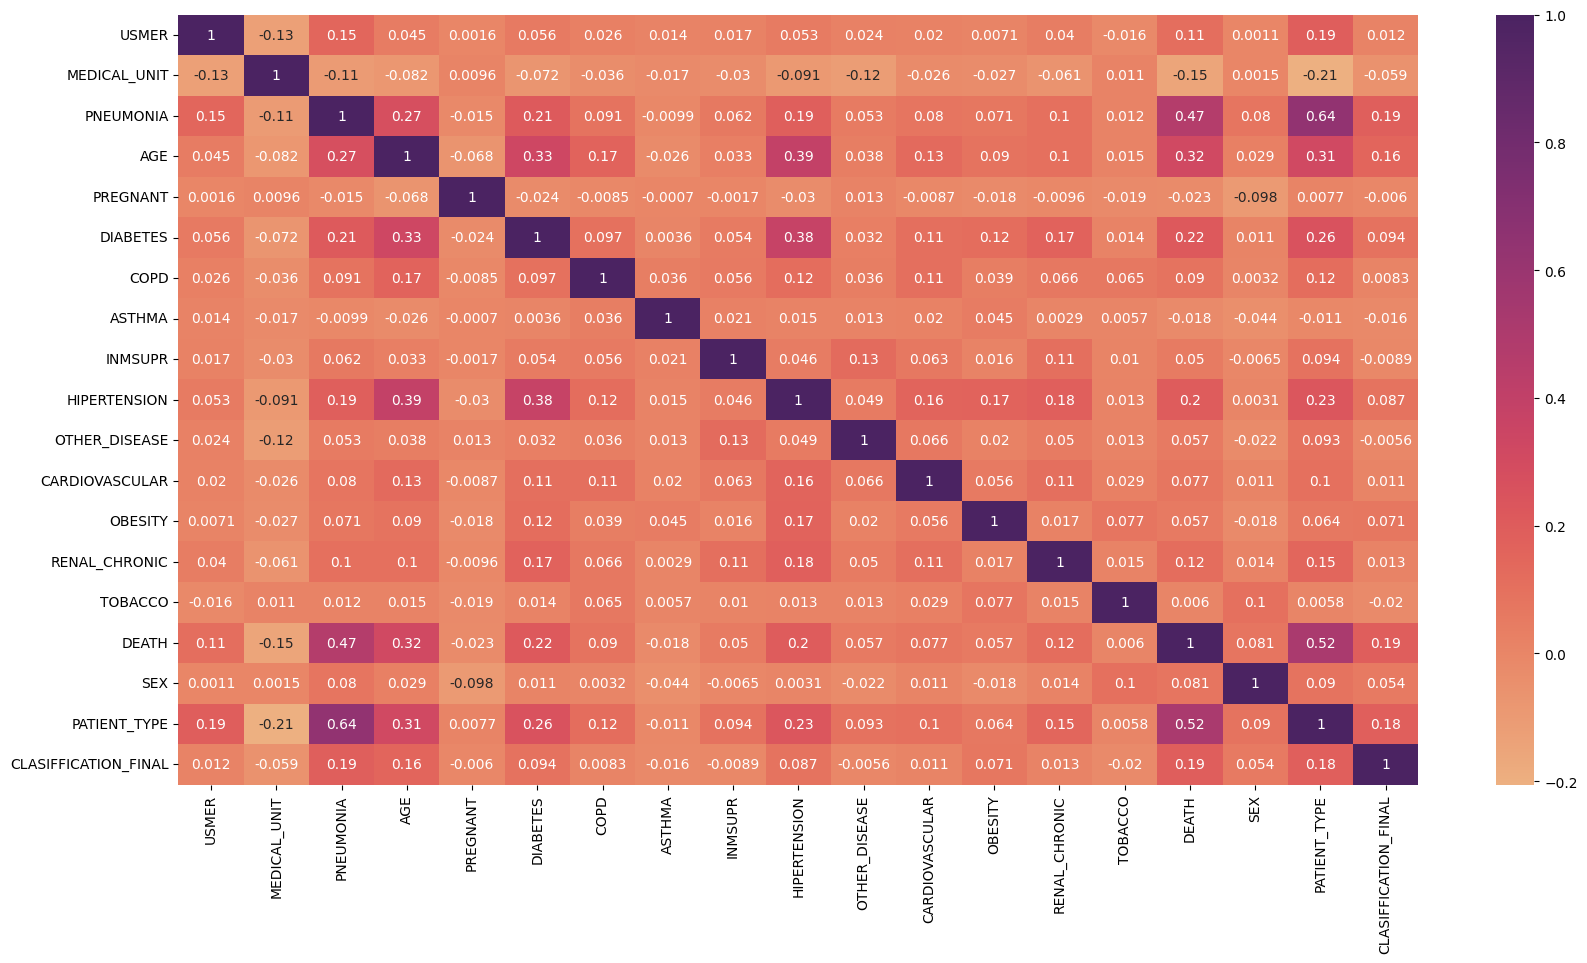

In [ ]:
plt.figure(figsize = (20,10)
sns.heatmap(df.corr() , annot = True , cmap = "flare")

In [ ]:
x=df.drop('DEATH',axis=1).values
y=df['DEATH'].values

# **MODELING**

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train , x_test , y_train , y_test = train_test_split(x,y, test_size=0.8, random_state=42)

In [ ]:
import numpy as np

# Check unique classes in y_train
unique_classes = np.unique(y)
print(f"Unique classes in y_train: {unique_classes}")

Unique classes in y_train: [0 1]


In [ ]:
from imblearn.under_sampling import RandomUnderSampler
X_under, y_under = RandomUnderSampler().fit_resample(x,y)
print(X_under.shape, y_under.shape)

(153884, 18) (153884,)


In [ ]:
x_train , x_test , y_train , y_test = train_test_split(X_under, y_under , test_size=0.8, random_state=42)

**A. Model Training with Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=7,n_estimators= 100)
rf.fit(x_train, y_train)

RandomForestClassifier(max_depth=7)

In [ ]:
rf.score(x_train, y_train)

0.9105796724720562

In [ ]:
rf.score(x_test,y_test)

0.9099571108295156

In [ ]:
y_pred_rf = rf.predict(x_test)

In [ ]:
y_pred_rf

array([0, 1, 0, ..., 0, 0, 1], dtype=int32)

**Model Evaluation with Confusion Matrix**

The confusion matrix demonstrates the model's ability to differentiate between patients who recovered and those who did not. It offers a concise visual representation of false positives and false negatives, which are crucial metrics for assessing the performance of medical diagnostic models.

In [ ]:
from sklearn.metrics import confusion_matrix , classification_report

rf_confu = confusion_matrix(y_test , y_pred_rf)
rf_confu

array([[53469,  8158],
       [ 2927, 58554]])

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

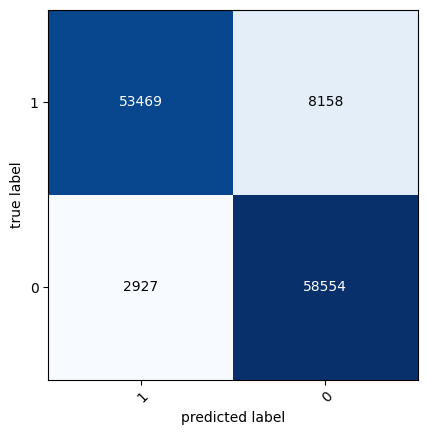

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
plot_confusion_matrix(rf_confu , class_names=["1" , "0"])

In [ ]:
print (classification_report(y_test  , rf.predict(x_test)))

              precision    recall  f1-score   support

           0       0.95      0.87      0.91     61627
           1       0.88      0.95      0.91     61481

    accuracy                           0.91    123108
   macro avg       0.91      0.91      0.91    123108
weighted avg       0.91      0.91      0.91    123108



In [ ]:
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Accuracy: {accuracy_rf:.2f}')

Accuracy: 0.91


**B. Model Evaluation with XGBoost**

0.9045035092279698
0.9054813659550963


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

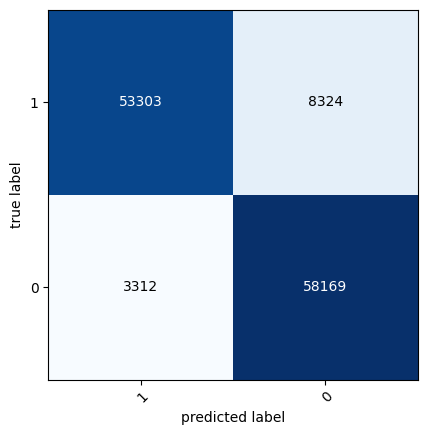

In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators= 5 , max_depth= 3)

xgb.fit(x_train , y_train)

print (xgb.score(x_train , y_train))
print (xgb.score(x_test , y_test))

y_pred_xgb = xgb.predict(x_test)

xgb_confu = confusion_matrix(y_test , xgb.predict(x_test))
xgb_confu

from mlxtend.plotting import plot_confusion_matrix
plot_confusion_matrix(xgb_confu , class_names=["1" , "0"])

In [ ]:
print (classification_report(y_test  , y_pred_xgb))

              precision    recall  f1-score   support

           0       0.94      0.86      0.90     61627
           1       0.87      0.95      0.91     61481

    accuracy                           0.91    123108
   macro avg       0.91      0.91      0.91    123108
weighted avg       0.91      0.91      0.91    123108



In [ ]:
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f'Accuracy: {accuracy_xgb:.2f}')

Accuracy: 0.91


**C. Model Training and Confusion Matrix for Logistic Regression**

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0.9022615024694567
0.9043928907950742


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

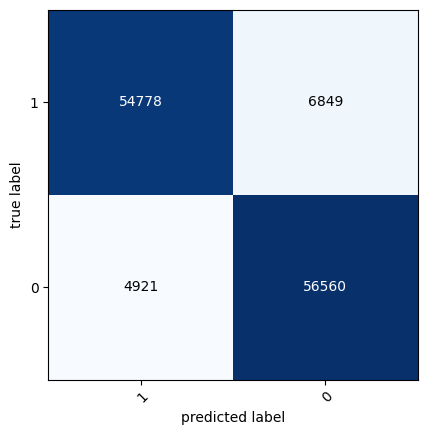

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

lr = LogisticRegression()
lr.fit(x_train, y_train)

print(lr.score(x_train, y_train))
print(lr.score(x_test, y_test))

lr_confu = confusion_matrix(y_test, lr.predict(x_test))
plot_confusion_matrix(conf_mat=lr_confu, class_names=["1", "0"])

In [ ]:
print (classification_report(y_test  , lr.predict(x_test)))

              precision    recall  f1-score   support

           0       0.92      0.89      0.90     61627
           1       0.89      0.92      0.91     61481

    accuracy                           0.90    123108
   macro avg       0.90      0.90      0.90    123108
weighted avg       0.90      0.90      0.90    123108



In [ ]:
accuracy_lr = accuracy_score(y_test, lr.predict(x_test))
print(f'Accuracy: {accuracy_lr:.2f}')

Accuracy: 0.90


**D. Model Training and Confusion Matrix for Naive Bayes**

0.8674291655835716
0.8685788088507652


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

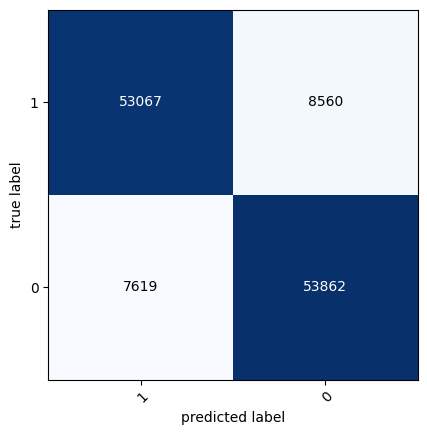

In [ ]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(x_train, y_train)

print(nb.score(x_train, y_train))
print(nb.score(x_test, y_test))

nb_confu = confusion_matrix(y_test, nb.predict(x_test))
plot_confusion_matrix(conf_mat=nb_confu, class_names=["1", "0"])

In [ ]:
print (classification_report(y_test  , nb.predict(x_test)))

              precision    recall  f1-score   support

           0       0.87      0.86      0.87     61627
           1       0.86      0.88      0.87     61481

    accuracy                           0.87    123108
   macro avg       0.87      0.87      0.87    123108
weighted avg       0.87      0.87      0.87    123108



In [ ]:
accuracy_nb = accuracy_score(y_test, nb.predict(x_test))
print(f'Accuracy: {accuracy_nb:.2f}')

Accuracy: 0.87


**E. Model Training and Confusion Matrix for Decision Tree**

0.9023589810241747
0.9036618253890892


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

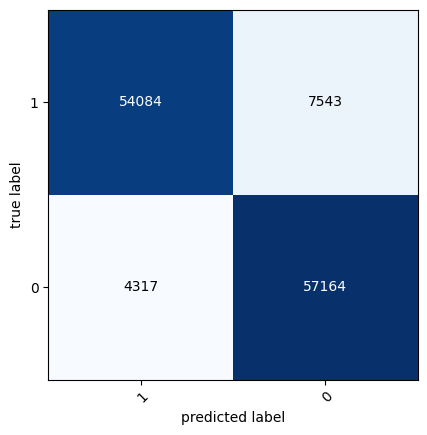

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(max_depth=3)
dt.fit(x_train, y_train)

print(dt.score(x_train, y_train))
print(dt.score(x_test, y_test))

dt_confu = confusion_matrix(y_test, dt.predict(x_test))
plot_confusion_matrix(conf_mat=dt_confu, class_names=["1", "0"])

In [ ]:
print (classification_report(y_test  , dt.predict(x_test)))

              precision    recall  f1-score   support

           0       0.93      0.88      0.90     61627
           1       0.88      0.93      0.91     61481

    accuracy                           0.90    123108
   macro avg       0.90      0.90      0.90    123108
weighted avg       0.90      0.90      0.90    123108



In [ ]:
accuracy_dt = accuracy_score(y_test, dt.predict(x_test))
print(f'Accuracy: {accuracy_dt:.2f}')

Accuracy: 0.90


**F. Model Training and Confusion Matrix for SVM**

0.887867169222771
0.888049517496832


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

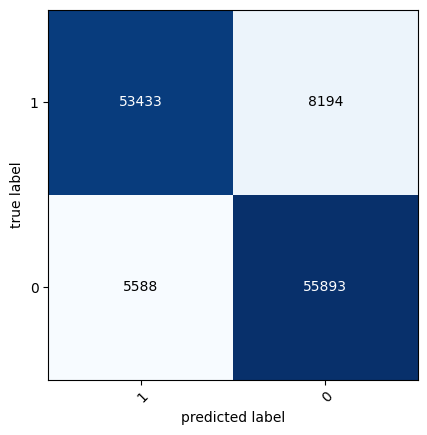

In [ ]:
from sklearn.svm import SVC

svm = SVC(kernel='linear')
svm.fit(x_train, y_train)

print(svm.score(x_train, y_train))
print(svm.score(x_test, y_test))

svm_confu = confusion_matrix(y_test, svm.predict(x_test))
plot_confusion_matrix(conf_mat=svm_confu, class_names=["1", "0"])


In [ ]:
print (classification_report(y_test  , svm.predict(x_test)))

              precision    recall  f1-score   support

           0       0.91      0.87      0.89     61627
           1       0.87      0.91      0.89     61481

    accuracy                           0.89    123108
   macro avg       0.89      0.89      0.89    123108
weighted avg       0.89      0.89      0.89    123108



In [ ]:
accuracy_svm = accuracy_score(y_test, svm.predict(x_test))
print(f'Accuracy: {accuracy_svm:.2f}')

Accuracy: 0.89


**G. Model Training and Confusion Matrix for AdaBoost)**

0.8853002339485313
0.8863680670630666


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

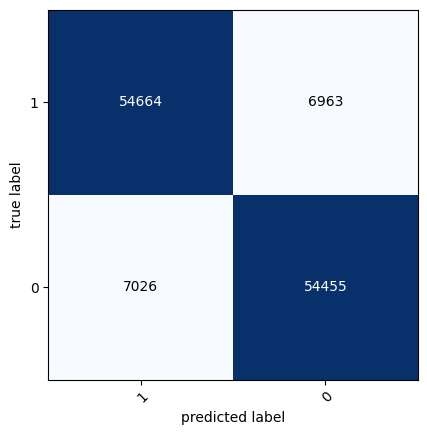

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(n_estimators=5)
ada.fit(x_train, y_train)

print(ada.score(x_train, y_train))
print(ada.score(x_test, y_test))

ada_confu = confusion_matrix(y_test, ada.predict(x_test))
plot_confusion_matrix(conf_mat=ada_confu, class_names=["1", "0"])

In [ ]:
print (classification_report(y_test  , ada.predict(x_test)))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89     61627
           1       0.89      0.89      0.89     61481

    accuracy                           0.89    123108
   macro avg       0.89      0.89      0.89    123108
weighted avg       0.89      0.89      0.89    123108



In [ ]:
accuracy_ada = accuracy_score(y_test, ada.predict(x_test))
print(f'Accuracy: {accuracy_ada:.2f}')

Accuracy: 0.89


**Model Initialization and ROC Curve Plotting**

In this, an assortment of machine learning algorithms is instantiated, such as Logistic Regression, Naive Bayes, Decision Tree, SVM, AdaBoost, RandomForest, and XGBoost. The script encompasses a procedure to train each model on the dataset, make predictions, and plot the Receiver Operating Characteristic (ROC) curves for each model. The ROC curve is a graphical depiction of a model's diagnostic capability, illustrating the balance between the true positive rate and the false positive rate. The area under the curve (AUC) for each model offers a single metric of overall performance, irrespective of the classification threshold.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



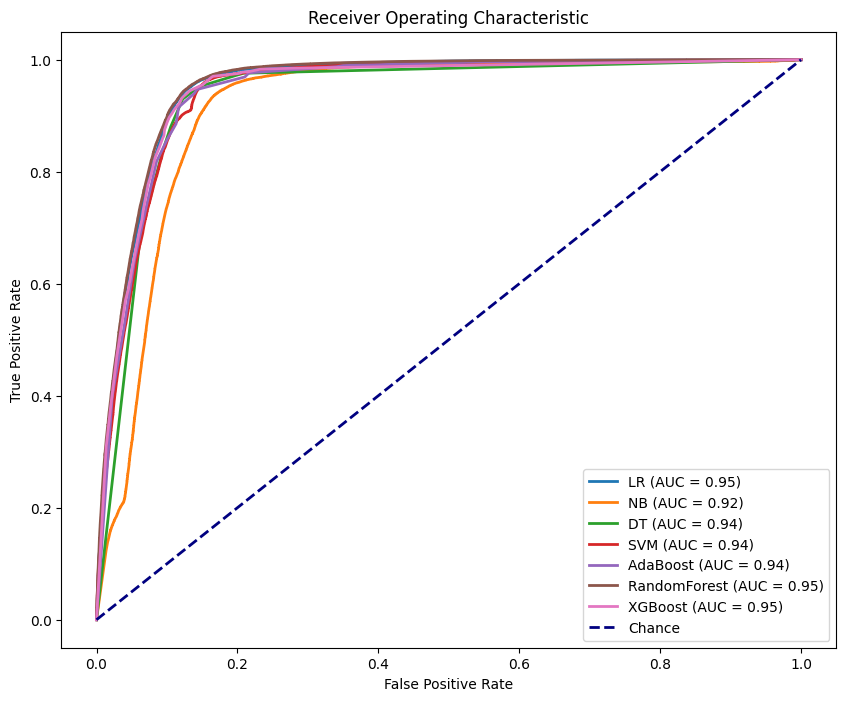

In [ ]:
# Initialize figure
plt.figure(figsize=(10, 8))

models = [
    ('LR', LogisticRegression()),
    ('NB', GaussianNB()),
    ('DT', DecisionTreeClassifier(max_depth=3)),
    ('SVM', SVC(kernel='linear')),
    ('AdaBoost', AdaBoostClassifier(n_estimators=5)),
    ('RandomForest', RandomForestClassifier(max_depth=7 ,n_estimators= 100)),
    ('XGBoost',XGBClassifier(n_estimators= 5 , max_depth= 3))
]

# Train, predict, and plot ROC for each model
for name, model in models:
    model.fit(x_train, y_train)

    if hasattr(model, "predict_proba"):
        # For models with predict_proba method
        probs = model.predict_proba(x_test)[:, 1]
    else:
        # For models that only have decision_function method
        probs = model.decision_function(x_test)
        probs = (probs - probs.min()) / (probs.max() - probs.min())  # Scale to [0,1]

    fpr, tpr, thresholds = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

# Plot Base Rate ROC
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance')

# Adjusting the Graph
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


**ROC Curve Graph**

The graph shows the Receiver Operating Characteristic (ROC) curves for all the models initialized in the previous phase. Each line corresponds to the performance of a distinct model, with the Area Under the Curve (AUC) score displayed in the legend, enabling a clear comparison of their predictive capabilities. A diagonal dashed line representing 'Chance' is included as a reference for the performance of a random guess. The closer the curve follows the left-hand and top borders of the ROC space, the more accurate the test. Consequently, curves that ascend rapidly towards the top-left corner indicate models with superior performance.

# **CONCLUSION**

The comprehensive analysis in this study examined the predictive abilities of different machine learning models in forecasting COVID-19 patient outcomes. Through rigorous training, testing, and validation, the study demonstrates that machine learning can be a powerful tool in anticipating the progression of patient health in response to COVID-19. The ROC curves and AUC values reveal the nuanced effectiveness of each algorithm, with some models exhibiting superior performance and others providing insights into the limitations within the data and features. As the medical community continues to navigate the unpredictability of COVID-19, the findings from this analysis emphasize the potential of machine learning to support clinical decision-making processes, ultimately enhancing patient care and resource allocation during global health emergencies.